In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import zipline
import pytz
import datetime as dt
from pymc3.distributions.timeseries import GaussianRandomWalk
import scipy.optimize as sco


In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [4]:
reg = np.polyfit(x, y, 1)
print(reg)

[ 2.02995907  3.90142553]


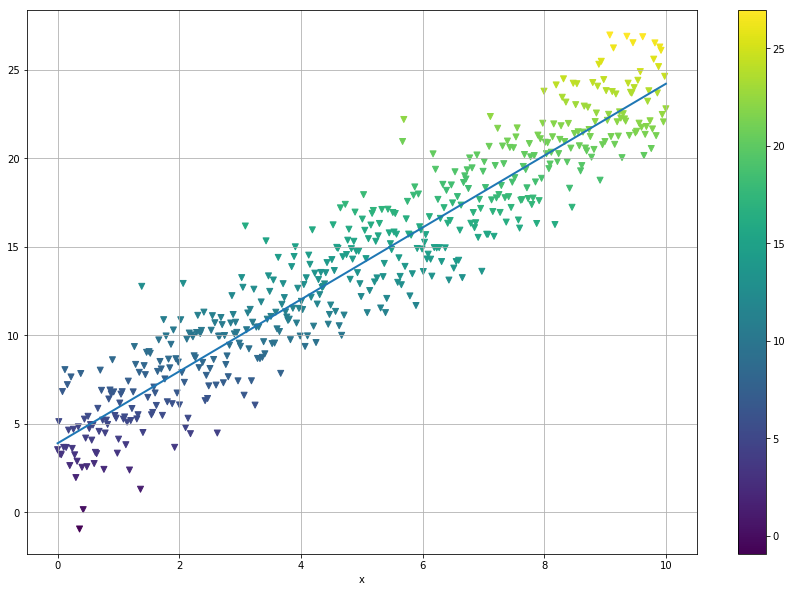

In [5]:
plt.scatter(x, y, c=y, marker='v')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')


In [6]:
%%time
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y_est = alpha + beta * x
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start)

Optimization terminated successfully.
         Current function value: 1064.096788
         Iterations: 16
         Function evaluations: 24

100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


         Gradient evaluations: 24
CPU times: user 21.8 s, sys: 1.21 s, total: 23 s
Wall time: 24.7 s


In [7]:
trace[0]

{'alpha': 4.0163337526362479,
 'beta': 2.0058512713709535,
 'sigma': 2.0200599890281077,
 'sigma_interval_': -1.3738036855005755}

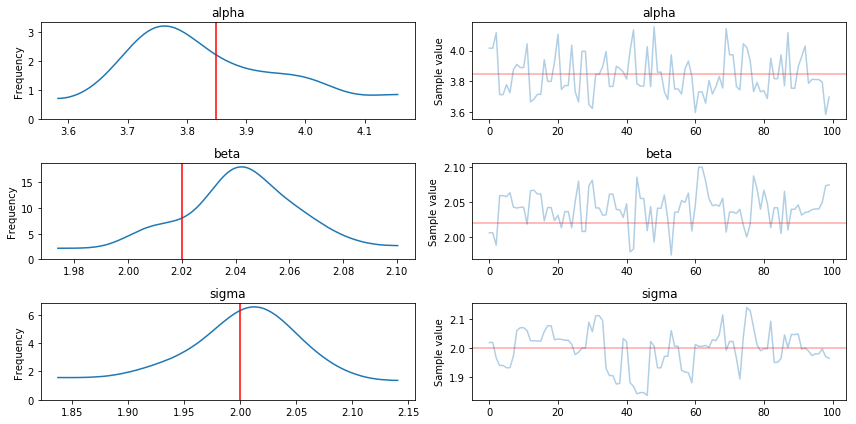

In [8]:
fig = pm.traceplot(trace, lines={'alpha': 3.85, 'beta': 2.02, 'sigma': 2})
plt.figure(figsize=(8,8))

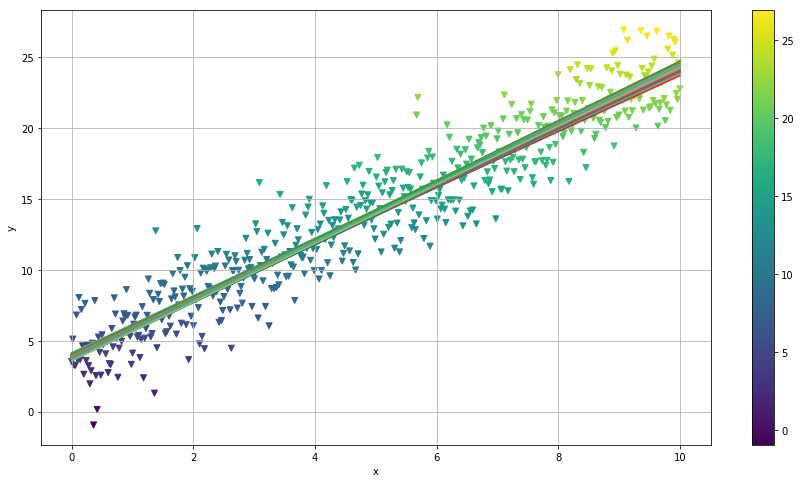

In [9]:
plt.figure(figsize=(15,8))
plt.scatter(x, y, c=y, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

In [10]:
dt = zipline.data.load_from_yahoo(stocks=['GLD', 'GDX'],
                                    end=dt.datetime(2014, 3, 15, 0, 0, 0, 0, pytz.utc)).dropna()
dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1967 entries, 2006-05-22 to 2014-03-14
Data columns (total 2 columns):
GDX    1967 non-null float64
GLD    1967 non-null float64
dtypes: float64(2)
memory usage: 46.1 KB


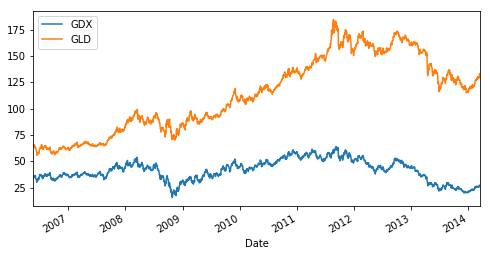

In [11]:
dt.plot(figsize=(8, 4))

In [12]:
dt.ix[-1] / dt.ix[0] - 1

GDX   -0.215999
GLD    1.038285
dtype: float64

In [13]:
dt.corr()

,GDX,GLD
GDX,1.00000,0.46696
GLD,0.46696,1.00000


In [14]:
dt.index

DatetimeIndex(['2006-05-22', '2006-05-23', '2006-05-24', '2006-05-25',
               '2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05',
               ...
               '2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14'],
              dtype='datetime64[ns, UTC]', name=u'Date', length=1967, freq=None)

In [15]:
mpl_dates = mpl.dates.date2num(dt.index.to_pydatetime())

In [16]:
mpl_dates

array([ 732453.,  732454.,  732455., ...,  735304.,  735305.,  735306.])

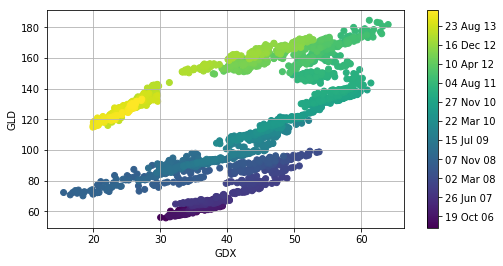

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(dt['GDX'], dt['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

In [18]:
%%time
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y_est = alpha + beta * dt['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed=dt['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start)

         Current function value: 16114.770709
         Iterations: 33
         Function evaluations: 107
         Gradient evaluations: 96


100%|██████████| 100/100 [01:19<00:00,  5.11it/s]

CPU times: user 1min 36s, sys: 2.16 s, total: 1min 38s
Wall time: 1min 38s


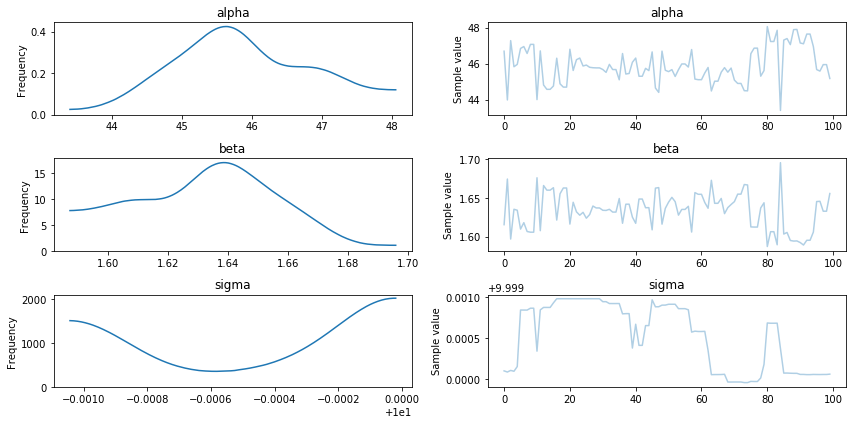

In [19]:
fig = pm.traceplot(trace)
plt.figure(figsize=(8,8))

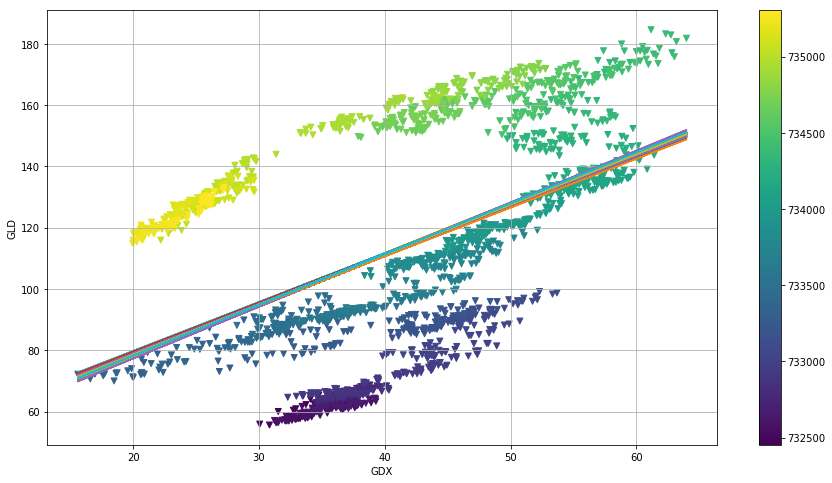

In [20]:
plt.figure(figsize=(15,8))
plt.scatter(dt['GDX'], dt['GLD'], c=mpl_dates, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(dt['GDX'], trace['alpha'][i] + trace['beta'][i] * dt['GDX'])

In [21]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 1. / .02, testval=.1)
    sigma_beta  = pm.Exponential('sigma_beta' , 1. / .02, testval=.1)

In [22]:
subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape=len(dt) / subsample_alpha)
    beta  = GaussianRandomWalk('beta' , sigma_beta**-2 , shape=len(dt) / subsample_beta)
    
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [23]:
len(dt.dropna().GDX.values)

1967

In [24]:
with model_randomwalk:
    regression = alpha_r + beta_r * dt.GDX.values[:1950]
    
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD', mu=regression, sd=sd, observed=dt.GLD.values[:1950])

In [25]:
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b)
    
    step = pm.NUTS(scaling=start)
    trac_rw = pm.sample(100, step, start=start)

100%|██████████| 100/100 [04:59<00:00,  4.28s/it]


In [26]:
np.shape(trac_rw['alpha'])

(100, 39)

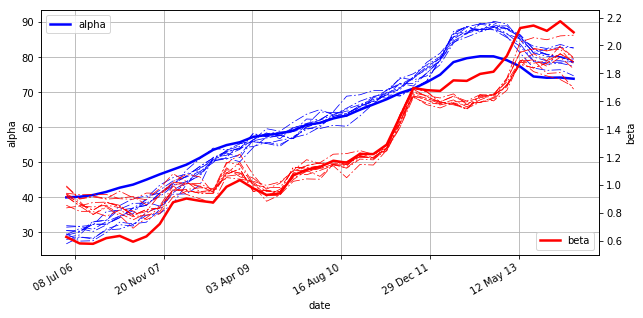

In [27]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), 39)
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.plot(part_dates, np.mean(trac_rw['alpha'], axis=0), 'b', lw=2.5, label='alpha')
for i in range(45, 55):
    plt.plot(part_dates, trac_rw['alpha'][i], 'b-.', lw=.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.axis('tight')
plt.grid(True)
plt.legend(loc=2)
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b %y'))
ax2 = ax1.twinx()
plt.plot(part_dates, np.mean(trac_rw['beta'], axis=0), 'r', lw=2.5, label='beta')
for i in range(45, 55):
    plt.plot(part_dates, trac_rw['beta'][i], 'r-.', lw=.75)
plt.ylabel('beta')
plt.legend(loc=4)
fig.autofmt_xdate()

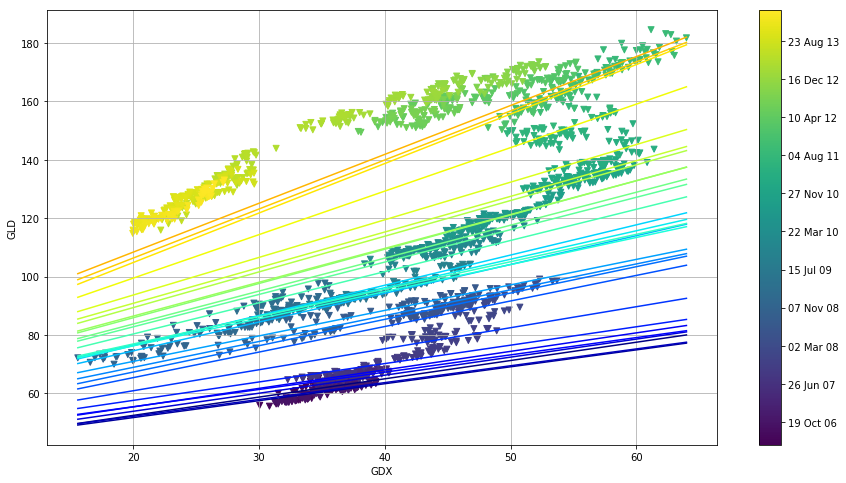

In [28]:
plt.figure(figsize=(15, 8))
plt.scatter(dt['GDX'], dt['GLD'], c=mpl_dates, marker='v')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(dt['GDX']), max(dt['GDX']))
for i in range(29):
    alpha_rw = np.mean(trac_rw['alpha'].T[i])
    beta_rw = np.mean(trac_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, color=plt.cm.jet(256 * i / 39))

In [29]:
symbols = ['NOW', 'CRM', 'MSFT', 'GLD', 'DB']
noa = len(symbols)

In [31]:
%%time
df = pd.DataFrame()
start = '2014-09-22'
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'yahoo', start)['Adj Close']


NOW
CRM
MSFT
GLD
DB
CPU times: user 325 ms, sys: 62.1 ms, total: 388 ms
Wall time: 4.24 s


In [32]:
df.head()

,NOW,CRM,MSFT,GLD,DB
Date,,,,,
2014-09-22,60.599998,57.320000,44.042786,116.849998,34.984598
2014-09-23,59.169998,56.810001,43.574844,117.599998,34.389986
2014-09-24,60.070000,57.660000,44.061505,117.050003,34.857876
2014-09-25,58.400002,55.919998,43.088182,117.389999,34.156042
2014-09-26,59.560001,56.560001,43.434459,117.059998,34.477715


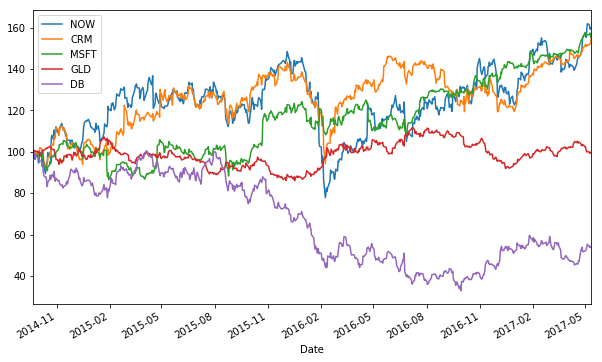

In [36]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [37]:
rets = np.log(df / df.shift(1))

In [38]:
rets.mean() * 252

NOW     0.177872
CRM     0.166902
MSFT    0.166706
GLD    -0.000065
DB     -0.235951
dtype: float64

In [39]:
rets.cov() * 252

,NOW,CRM,MSFT,GLD,DB
NOW,0.136848,0.067606,0.034548,-0.009265,0.057260
CRM,0.067606,0.093453,0.033322,-0.006548,0.044284
MSFT,0.034548,0.033322,0.055527,-0.005210,0.032381
GLD,-0.009265,-0.006548,-0.005210,0.022635,-0.014259
DB,0.057260,0.044284,0.032381,-0.014259,0.170624


In [42]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.24890397,  0.16186761,  0.23588408,  0.21889508,  0.13444926])

In [45]:
np.dot(weights.T, rets.mean()) * 252

0.078874806585420731

In [46]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.035197129632134921

In [47]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.18760898068092297

In [49]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

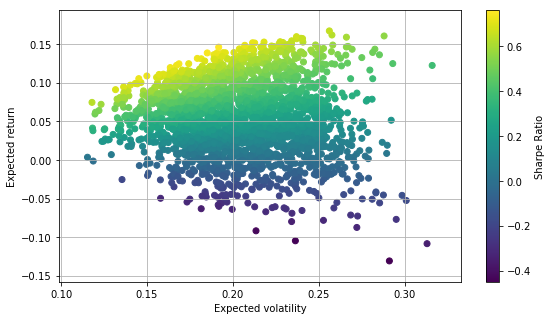

In [52]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [53]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [54]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [55]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [63]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 121 ms, sys: 21 ms, total: 142 ms
Wall time: 187 ms


In [64]:
opts

     fun: -0.76908033762235117
     jac: array([  5.59486449e-04,   4.88221645e-04,  -3.84904444e-04,
         3.91341746e-04,   2.05301102e+00,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  9.24076205e-02,   1.55876981e-01,   5.43636015e-01,
         2.08079384e-01,   2.21505892e-16])

In [65]:
opts['x'].round(3)

array([ 0.092,  0.156,  0.544,  0.208,  0.   ])

In [66]:
symbols

['NOW', 'CRM', 'MSFT', 'GLD', 'DB']

In [67]:
statistics(opts['x'].round(3))

array([ 0.13307557,  0.17303205,  0.76908045])

In [68]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [70]:
%%time
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 113 ms, sys: 3.96 ms, total: 117 ms
Wall time: 120 ms


In [71]:
optv['x'].round(3)

array([ 0.033,  0.051,  0.194,  0.656,  0.065])

In [72]:
statistics(optv['x'].round(3))

array([ 0.03134341,  0.11066699,  0.2832228 ])

In [73]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [74]:
def min_func_port(weights):
    return statistics(weights)[1]

In [75]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 9.61 s, sys: 76.1 ms, total: 9.69 s
Wall time: 9.82 s


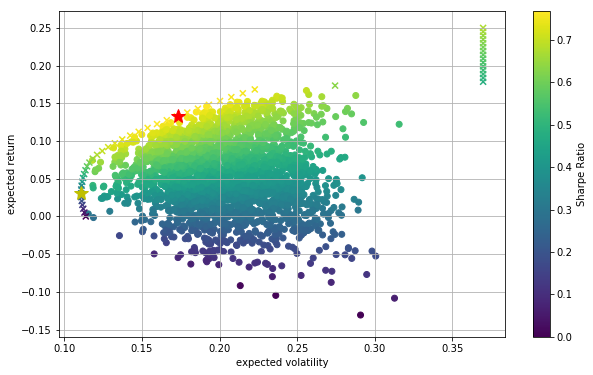

In [76]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0)
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe Ratio')